In [2]:
# Boilerplate
import glob
import os
import sys
import weakref

import time
import random
from collections import deque
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla

**Template for environment:**

```
def step(self,action):
    # Do something
    return state (obs), reward, terminal_state (done), _ (extra_info)  

```

```
def reset(self):
    # Do something
```

In [2]:
IM_WIDTH = 640
IM_HEIGHT = 480
SHOW_PREVIEW = False
SECONDS_PER_EPISODE = 60 # Originally 10 changed to 20
NUM_NPC_CARS = 10

In [3]:
#  Global functions

def get_actor_display_name(actor, truncate=250):
    name = ' '.join(actor.type_id.replace('_', '.').title().split('.')[1:])
    return (name[:truncate - 1] + u'\u2026') if len(name) > truncate else name

In [4]:
class CarEnv():

    # self.SHOW_CAM = SHOW_PREVIEW
    # self.STEER_AMT = 1
    # self.im_width = IM_WIDTH
    # self.im_height = IM_HEIGHT
    # self.front_camera = None
    # self.log_depth_camera = None
    # self.cam_images = []
    # self.depth_maps = []
    # self.num_car_npcs = NUM_NPC_CARS

    def __init__(self):
        # Environment Variables

        self.SHOW_CAM = SHOW_PREVIEW
        self.STEER_AMT = 1
        self.im_width = IM_WIDTH
        self.im_height = IM_HEIGHT
        self.front_camera = None
        self.log_depth_camera = None
        self.semantic_segmentation_map = None
        self.cam_images = []
        self.depth_maps = []
        self.segmentation_maps = []
        self.num_car_npcs = NUM_NPC_CARS
    
        # Connect environment to CARLA
        self.client = carla.Client('localhost', 2000)
        # self.client.set_timeout(5.0)
        self.world = self.client.get_world()
        self.blueprint_library = self.world.get_blueprint_library()
        self.vehicle_bp = self.blueprint_library.filter('vehicle.mini.cooper_s')[0]
        self.vehicle_bp.set_attribute('role_name','ego') # Recommended in documentation
        # Set up the TM in synchronous mode
        self.traffic_manager = self.client.get_trafficmanager()
            
    def reset(self):
        self.collision_hist = [] # Sense collition when the whicle is spawn (because it falls from the sky). Also activated by bumps in the road.
        self.collision_hist_detail = []
        self.actor_list = []

        # Creating the ego vehicle using the blueprint from __init__()
        self.spawn_point = random.choice(self.world.get_map().get_spawn_points())
        self.vehicle = self.world.spawn_actor(self.vehicle_bp,self.spawn_point)
        self.actor_list.append(self.vehicle)

        # Creating the RBGA camera
        self.rgb_cam_bp = self.blueprint_library.find('sensor.camera.rgb')
        self.rgb_cam_bp.set_attribute('image_size_x',f'{self.im_width}')
        self.rgb_cam_bp.set_attribute('image_size_y',f'{self.im_height}')
        self.rgb_cam_bp.set_attribute('fov',f'110')

        cam_spawn_point = carla.Transform(carla.Location(x=2.5, z=0.7)) # Might need change depending on the car. x=> moves forward and z=> moves up
        self.rgb_cam = self.world.spawn_actor(self.rgb_cam_bp, cam_spawn_point, attach_to=self.vehicle)
        self.actor_list.append(self.rgb_cam)
        self.rgb_cam.listen(lambda data: self.process_img(data))

        # Creating a depth camera
        self.depth_cam_bp = self.blueprint_library.find('sensor.camera.depth')
        self.depth_cam_bp.set_attribute('image_size_x',f'{self.im_width}')
        self.depth_cam_bp.set_attribute('image_size_y',f'{self.im_height}')
        self.depth_cam_bp.set_attribute('fov',f'110')
    
        depth_spawn_point = carla.Transform(carla.Location(x=2.5, z=0.7)) # Might need change depending on the car. x=> moves forward and z=> moves up
        self.depth_camera = self.world.spawn_actor(self.depth_cam_bp, depth_spawn_point, attach_to=self.vehicle)
        self.actor_list.append(self.depth_camera)
        self.depth_camera.listen(lambda data: self.process_depth(data))

        # Creating a semantic segmentation camera

        self.segmentation_cam_bp = self.blueprint_library.find('sensor.camera.semantic_segmentation')
        self.segmentation_cam_bp.set_attribute('image_size_x',f'{self.im_width}')
        self.segmentation_cam_bp.set_attribute('image_size_y',f'{self.im_height}')
        self.segmentation_cam_bp.set_attribute('fov',f'110')

        segmentation_spawn_point = carla.Transform(carla.Location(x=2.5, z=0.7)) # Depends on the car. x=> moves forward and z=> moves up
        self.segmentation_camera = self.world.spawn_actor(self.segmentation_cam_bp, segmentation_spawn_point, attach_to=self.vehicle)
        self.actor_list.append(self.segmentation_camera)
        self.segmentation_camera.listen(lambda segmented_data: self.process_segmentation(segmented_data))
        
        # Getting the vehicle started
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0, steer=0.0)) # It makes the car be ready quickly
        time.sleep(4.0)

        self.collision_sensor_bp = self.blueprint_library.find('sensor.other.collision')
        collision_spawn_point = carla.Transform(carla.Location(x=2.5, z=0.7))
        self.collision_sensor = self.world.spawn_actor(self.collision_sensor_bp, collision_spawn_point, attach_to=self.vehicle)
        self.actor_list.append(self.collision_sensor)
        self.collision_sensor.listen(lambda event: self.on_collision(event))

        # Creates car non-playing characters in the environment
        if self.num_car_npcs:
            self.spawn_npc_cars()
            
        while (self.front_camera is None) or (self.log_depth_camera is None) or (self.semantic_segmentation_map is None):
            time.sleep(0.01)

        self.episode_start = time.time()

        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0, steer=0.0)) # It makes the car be ready quickly

        return self.front_camera, self.log_depth_camera, self.semantic_segmentation_map, (0,0), 0, False, None

    def on_collision(self,event):
        # I might need to pass weak reference to the lambda in the call to this method to avoid circular reference.
        actor_type = get_actor_display_name(event.other_actor)
        impulse = event.normal_impulse
        intensity = math.sqrt(impulse.x**2 + impulse.y**2 + impulse.z**2)
        frame = event.frame
        details = (frame,actor_type,intensity)
        self.collision_hist.append(event)
        self.collision_hist_detail.append(details)

    def process_img(self,image):
        i = np.array(image.raw_data) # raw_data: Array of BGRA 32-bit pixels. Type: bites. See documentation:
                                     # https://carla.readthedocs.io/en/0.9.14/ref_sensors/#rgb-camera
                                     # https://carla.readthedocs.io/en/0.9.9/python_api/#carla.Image
        imgRGBA = i.reshape((self.im_height,self.im_width,4))
        imgRGB = imgRGBA[:,:,:3] 
        self.cam_images.append(imgRGB/255.0)
        if self.SHOW_CAM: 
            cv2.imshow("",imgRGB)
            cv2.waitKey(1)
        # return imgRGB/255.0 # Normalize RGB values for NN processing
        self.front_camera = imgRGB/255.0
    
    def to_bgra_array(self,image):
        """Convert a CARLA raw image to a BGRA numpy array.
        Adapted from: https://github.com/carla-simulator/data-collector/blob/master/carla/image_converter.py"""
        array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
        array = np.reshape(array, (image.height, image.width, 4))
        return array
    
    def depth_to_array(self,image):
        """
        Convert an image containing CARLA encoded depth-map to a 2D array containing
        the depth value of each pixel normalized between [0.0, 1.0].
        Adapted from: https://github.com/carla-simulator/data-collector/blob/master/carla/image_converter.py
        """
        array = self.to_bgra_array(image)
        array = array.astype(np.float32)
        # Apply (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1).
        normalized_depth = np.dot(array[:, :, :3], [65536.0, 256.0, 1.0])
        normalized_depth /= 16777215.0  # (256.0 * 256.0 * 256.0 - 1.0)
        return normalized_depth
    
    def depth_to_logarithmic_grayscale(self,image):
        """
        Convert an image containing CARLA encoded depth-map to a logarithmic
        grayscale image array.
        "max_depth" is used to omit the points that are far enough.
        Adapted from: https://github.com/carla-simulator/data-collector/blob/master/carla/image_converter.py
        """
        normalized_depth = self.depth_to_array(image)
        # Convert to logarithmic depth.
        logdepth = np.ones(normalized_depth.shape) + \
            (np.log(normalized_depth) / 5.70378)
        logdepth = np.clip(logdepth, 0.0, 1.0)
        logdepth *= 255.0
        return logdepth
    
    def process_depth(self,image):
        depth_map = self.depth_to_logarithmic_grayscale(image)
        self.depth_maps.append(depth_map/255.0) # Added division to normalize between 0-1
        # return depth_map/255.0 # Normalize depth map values for NN processing
        self.log_depth_camera = depth_map/255.0

    def labels_to_array(self,image):
        """
        Convert an image containing CARLA semantic segmentation labels to a 2D array
        containing the label of each pixel.
        Adapted from: https://github.com/carla-simulator/data-collector/blob/master/carla/image_converter.py
        """
        return self.to_bgra_array(image)[:, :, 2]

    def labels_to_cityscapes_palette(self,image):
        """
        Convert an image containing CARLA semantic segmentation labels to
        Cityscapes palette.
        Adapted from: https://github.com/carla-simulator/data-collector/blob/master/carla/image_converter.py
        """
        classes = {
            0: [0, 0, 0],         # None
            1: [70, 70, 70],      # Buildings
            2: [190, 153, 153],   # Fences
            3: [72, 0, 90],       # Other
            4: [220, 20, 60],     # Pedestrians
            5: [153, 153, 153],   # Poles
            6: [157, 234, 50],    # RoadLines
            7: [128, 64, 128],    # Roads
            8: [244, 35, 232],    # Sidewalks
            9: [107, 142, 35],    # Vegetation
            10: [0, 0, 255],      # Vehicles
            11: [102, 102, 156],  # Walls
            12: [220, 220, 0]     # TrafficSigns
        }
        array = self.labels_to_array(image)
        result = np.zeros((array.shape[0], array.shape[1], 3))
        for key, value in classes.items():
            result[np.where(array == key)] = value
        return result

    def process_segmentation(self,image):
        segmentation_map = self.labels_to_cityscapes_palette(image)
        self.segmentation_maps.append(segmentation_map/255.0) # Added division to normalize between 0-1
        # return depth_map/255.0 # Normalize depth map values for NN processing
        self.semantic_segmentation_map = segmentation_map/255.0

    def spawn_npc_cars(self):
        self.car_npcs = []
        num_npcs = self.num_car_npcs
        # Spawn 5 vehicles randomly distributed throughout the map
        for i in range(0,num_npcs):
            car_npc = self.world.try_spawn_actor(
                random.choice(self.blueprint_library.filter('*vehicle*')), 
                random.choice(self.world.get_map().get_spawn_points())
            )
            if car_npc != None:
                car_npc.set_autopilot(True)
                # Randomly set the probability that a vehicle will ignore traffic lights
                self.traffic_manager.ignore_lights_percentage(car_npc, random.randint(0,50))
                self.actor_list.append(car_npc)
        
        # Start the vehichles
        # for car in self.car_npcs:
        #     car.set_autopilot(True)

    def manual_episode_end(self):
        for actor in carla_env.world.get_actors().filter('*vehicle*'):
            actor.destroy()
    
    def step(self,action):
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0,brake=0.0,steer=-1*self.STEER_AMT,reverse=False)) # Full left - Full Throttle
        elif action == 1:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0,brake=0.0,steer=-0.5*self.STEER_AMT,reverse=False)) # Left - Full Throttle
        elif action == 2:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.5,brake=0.0,steer=-0.5*self.STEER_AMT,reverse=False)) # Left - Half Throttle
        elif action == 3:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.5,brake=0.0,steer=-0.25*self.STEER_AMT,reverse=False)) # Soft Left - Half Throttle
        elif action == 4:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0,brake=0.0,steer=0*self.STEER_AMT,reverse=False)) # Straight - Full Throttle
        elif action == 5:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.5,brake=0.0,steer=0*self.STEER_AMT,reverse=False)) # Straight - Half Throttle
        elif action == 6:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.5,brake=0.0,steer=0.25*self.STEER_AMT,reverse=False)) # Soft Right - Half Throttle
        elif action == 7:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.5,brake=0.0,steer=0.5*self.STEER_AMT,reverse=False)) # Right - Half Throttle
        elif action == 8:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0,brake=0.0,steer=0.5*self.STEER_AMT,reverse=False)) # Right - Full Throttle
        elif action == 9:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0,brake=0.0,steer=1*self.STEER_AMT,reverse=False)) # Full Right - Full Throttle
        elif action == 10:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.0,brake=1.0,steer=0*self.STEER_AMT,reverse=False)) # Full Brake - Straight
        elif action == 11:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.0,brake=1.0,steer=-0.5*self.STEER_AMT,reverse=False)) # Full Brake - Left
        elif action == 12:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.0,brake=1.0,steer=0.5*self.STEER_AMT,reverse=False)) # Full Brake - Right
        # elif action == 13:
        #     self.vehicle.apply_control(carla.VehicleControl(throttle=1.0,brake=0.0,steer=0*self.STEER_AMT,reverse=True)) # Reverse - Full Throttle

        v = self.vehicle.get_velocity()
        kmph = int(3.6*math.sqrt(v.x**2+ v.y**2 + v.z**2)) # 3.6 to convert from m/s to km/h
        ang_v_vect = self.vehicle.get_angular_velocity()
        ang_v = int(math.sqrt(ang_v_vect.x**2+ ang_v_vect.y**2 + ang_v_vect.z**2))
        # other car attributes (https://carla.readthedocs.io/en/0.9.14/python_api/#carlaactor): 
        #                       get_acceleration() | m/s^2
        #                       get_angular_velocity() | deg/s
        motion_data = (kmph,ang_v)

        # Reward function
        terminal_reward = -100 # Originally -200
        if (len(self.collision_hist_detail) != 0) and (self.collision_hist_detail[-1][2] > 999):
            episode_end = True
            reward = terminal_reward
            print('episode_ended_due_collision')
        elif len(self.collision_hist_detail) != 0:
            collision_mag = [collision[2] for collision in self.collision_hist_detail]
            average_mag = sum(collision_mag)/len(collision_mag)
            if average_mag > 999:
                episode_end = True
                reward = terminal_reward
            else:
                episode_end = False
                reward = -average_mag/120 # Assumes 60s episode and one minor collission of magnitude 100 returns a reward of -50 (clumsy driving)
                                          # The idea is to handle minor 'collisions' that are result of road bumps in the environment
        elif kmph < 50: 
            episode_end = False
            reward = -1
        else:
            episode_end = False
            reward = 1

        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            episode_end = True
            print('episode_ended_due_timeout')
            
        # Environment observation
        # return self.front_camera, self.log_depth_camera, reward, episode_end, None ## Original recommendation 
        if (len(self.cam_images) < 4) or (len(self.depth_maps) < 4):
            return self.front_camera, self.log_depth_camera, self.semantic_segmentation_map, motion_data, reward, episode_end, None
        else:
            # Returns the last four frames to overcome 'temporal limitation'
            return self.cam_images[-4:], self.depth_maps[-4:], self.segmentation_maps[-4:], motion_data, reward, episode_end, None 

In [5]:
carla_env = CarEnv()

In [16]:
rgb_obs_0, depth_obs_0, segment_obs0, motion_0, step_reward_0, end_state_0, _ = carla_env.reset()

In [17]:
rgb_obs, depth_obs, segment_obs, motion, step_reward, end_state, _ = carla_env.step(3)

In [18]:
rgb_obs, depth_obs, segment_obs, motion, step_reward, end_state, _ = carla_env.step(11)

episode_ends


In [12]:
rgb_obs, depth_obs, segment_obs, motion, step_reward, end_state, _ = carla_env.step(2)

In [8]:
rgb_obs, depth_obs, segment_obs, motion, step_reward, end_state, _ = carla_env.step(6)

In [19]:
carla_env.manual_episode_end()

In [10]:
carla_env.depth_maps[-1].shape

(480, 640)

In [11]:
carla_env.cam_images[-1].shape

(480, 640, 3)

4


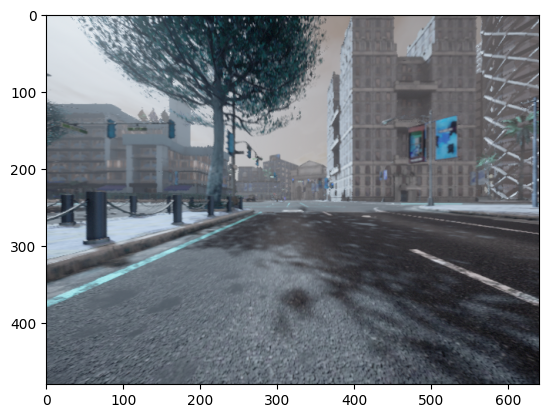

In [12]:
print(len(rgb_obs))
plt.imshow(rgb_obs[-1])

4


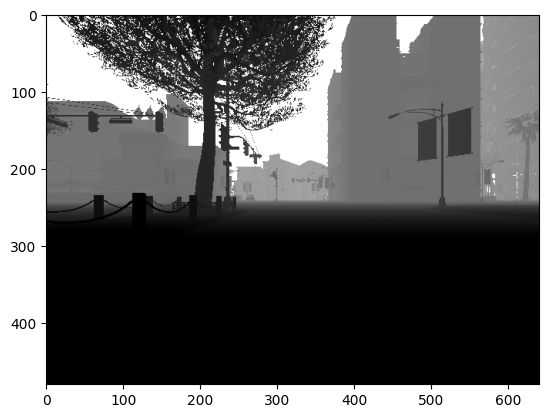

In [13]:
print(len(depth_obs))
plt.imshow(depth_obs[-1], cmap=plt.get_cmap('gray'))

4
(480, 640, 3)


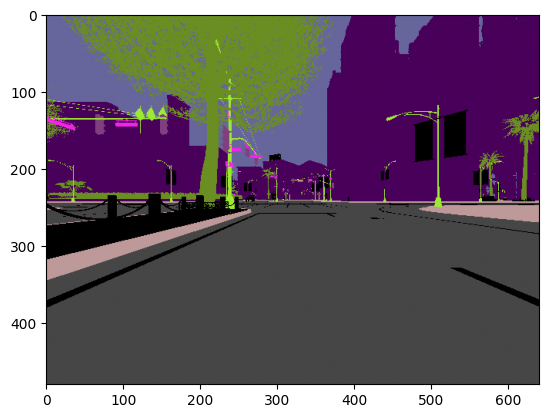

In [14]:
print(len(segment_obs))
print(segment_obs[-1].shape)
plt.imshow(segment_obs[-1])

In [15]:
print(len(carla_env.collision_hist))

print(carla_env.collision_hist[-1])

310
CollisionEvent(frame=12854, timestamp=90.172165, other_actor=00000140249AACD0)


In [16]:
for event in carla_env.collision_hist:
    print(event)

CollisionEvent(frame=12360, timestamp=81.449586, other_actor=0000014026BCB5A0)
CollisionEvent(frame=12668, timestamp=86.640308, other_actor=0000014026BCF6E0)
CollisionEvent(frame=12678, timestamp=86.831683, other_actor=0000014026BCF380)
CollisionEvent(frame=12679, timestamp=86.850971, other_actor=0000014026BCF920)
CollisionEvent(frame=12680, timestamp=86.870283, other_actor=0000014026BCB000)
CollisionEvent(frame=12680, timestamp=86.870283, other_actor=0000014026BCAB80)
CollisionEvent(frame=12681, timestamp=86.888025, other_actor=0000014026BCA940)
CollisionEvent(frame=12681, timestamp=86.888025, other_actor=0000014026BCA160)
CollisionEvent(frame=12682, timestamp=86.906746, other_actor=0000014026BCA820)
CollisionEvent(frame=12682, timestamp=86.906746, other_actor=0000014026BCBEA0)
CollisionEvent(frame=12683, timestamp=86.925183, other_actor=0000014026BCACA0)
CollisionEvent(frame=12683, timestamp=86.925183, other_actor=0000014026BCBC60)
CollisionEvent(frame=12684, timestamp=86.943241, oth

In [20]:
for event in carla_env.collision_hist_detail:
    print(event)

(20248, 'Building', 21004.044392970016)
(20248, 'Building', 21124.08594755793)


In [18]:
motion

(69, 0)

In [14]:
end_state

False

In [20]:
step_reward

1

In [16]:
rgb_obs, depth_obs, segment_obs, motion, step_reward, end_state, _ = carla_env.step(3)

In [20]:
carla_env.actor_list

In [21]:
print(carla_env.actor_list[3])

Actor(id=27, type=sensor.camera.semantic_segmentation)


In [13]:
carla_env.manual_episode_end()
#end_state

In [24]:
if end_state == True:
    carla_env.reset()

In [18]:
carla_env.actor_list

In [1]:
# for actor in carla_env.world.get_actors().filter('*vehicle*'):
#     print(actor)
#     print(actor.destroy())